In [1]:
# Hack to use uninstalled package in a notebook
import sys
sys.path.append('/media/marcelo/OS/Users/marx/Documents/marcelo/near/projects/program_synthesis/')

while sys.path[-1] == sys.path[-2]:
    sys.path.pop()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import program_synthesis
from importlib import reload
from functools import reduce
from tqdm import tqdm

import torch
import torch.nn as nn

In [121]:
import program_synthesis.karel as karel
import program_synthesis.karel.dataset.refine_env as env
import program_synthesis.karel.dataset.utils as utils
import program_synthesis.karel.dataset.mutation as mutation
import program_synthesis.karel.dataset.executor as executor
import program_synthesis.karel.models.modules.karel_common as karel_common
import program_synthesis.karel.models.modules as modules
import program_synthesis.tools.saver as saver

args = saver.ArgsDict(
        num_epochs=100, max_rollout_length=30, replay_buffer_size=16384, max_token_per_code=75,
        num_episodes=10, num_training_steps=10, batch_size=32, update_actor_epoch=10,
        rl_discount=.9, rl_eps_action=.1, rl_eps_parameter=.5, rl_alpha=.7,
        karel_io_enc='lgrl', lr=0.001, cuda=False)

_ = reload(karel)
_ = reload(env)

# Dataset

In [3]:
# Loading dataset
train_ds = karel.dataset.dataset.KarelTorchDataset(karel.dataset.dataset.relpath('../../data/karel/{}{}.pkl'.format('train', '')), lambda x: x)
test_ds = karel.dataset.dataset.KarelTorchDataset(karel.dataset.dataset.relpath('../../data/karel/{}{}.pkl'.format('test', '')), lambda x: x)

print("Train size:", len(train_ds))
print("Test size:", len(test_ds))

Train size: 1116854
Test size: 2500


In [4]:
from program_synthesis.karel.dataset import data

vocab = data.PlaceholderVocab(data.load_vocab(karel.dataset.dataset.relpath('../../data/karel/word.vocab')), 0)

print(len(vocab))

Loaded vocab /media/marcelo/OS/Users/marx/Documents/marcelo/near/projects/program_synthesis/program_synthesis/karel/../../data/karel/word.vocab: 43
43


In [5]:
# Display sequence length distribution among all examples
display = False

if display:
    for name, ds in zip("test train".split(), (test_ds, train_ds)):
        ds_loader = torch.utils.data.DataLoader(
                    ds, collate_fn=lambda x : x,shuffle=True
                )

        tokens = []
        for (ex,) in tqdm(ds_loader):
            tokens.append(len(ex.code_sequence))

        print(name, max(tokens))
        sns.distplot(tokens)
        plt.show()
else:
    print("Distributions plot skipped. Set `display=True` to see distributions.")

Distributions plot skipped. Set `display=True` to see distributions.


In [6]:
# Using example

example = train_ds[20]

print("CODE:", ' '.join(example.code_sequence))
print("INPUT TESTS:", len(example.input_tests))
print("TESTS:", len(example.tests))

CODE: DEF run m( pickMarker pickMarker turnLeft move m)
INPUT TESTS: 5
TESTS: 1


In [7]:
print(utils.beautify(' '.join(example.code_sequence)))

DEF run {
  pickMarker pickMarker turnLeft move
}


In [8]:
# Using data loader to iterate over the dataset
dataset_loader = torch.utils.data.DataLoader(
            test_ds, collate_fn=lambda x : x,shuffle=True
        )

total = 0

for idx, x in enumerate(dataset_loader):
    if idx <= 5: # Print 5 first elements
        print(x[0].guid)
    total +=1 

print("Total:", total)

e2e9f357c02beb45
2dbe199824820341
98615b5349e92aae
53c2f809b022da59
7d9397f549c5b00f
3e83d26953a12027
Total: 2500


In [9]:
len(example.tests)

1

In [10]:
def grid_from_pck(input, output):
    answer = []
    
    for grid_id in (input, output):
        grid = np.zeros((1, 15, 18, 18))
        grid.ravel()[grid_id] = 1
        answer.append(grid)
        
    return tuple(answer)

def grid_from_example(example, include_test=False):
    input = []
    output = []
    
    tests = example.input_tests if not include_test else example.input_tests + example.tests
    
    for test in tests:
        I, O = grid_from_pck(test['input'], test['output'])
        input.append(I)
        output.append(O)
        
    return np.concatenate(input), np.concatenate(output)

In [11]:
def compose(funcs):
    return lambda x : reduce(lambda y, f: f(y), funcs, x)

DEF run {
  pickMarker pickMarker turnLeft move
}


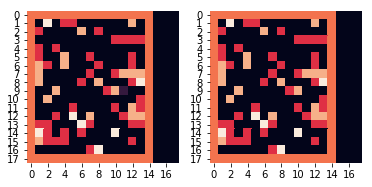

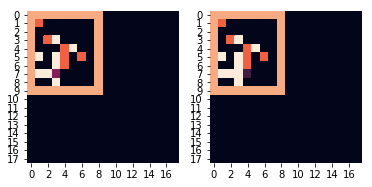

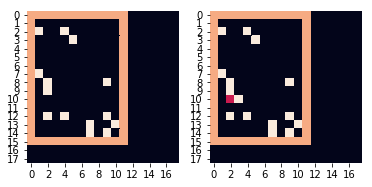

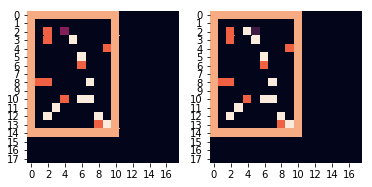

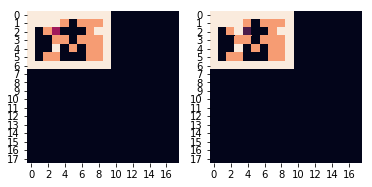

In [12]:
# Display tests
colors=None

print(utils.beautify(' '.join(example.code_sequence)))

for test in example.input_tests:
    fig = plt.figure()    
    inp_p = fig.add_subplot(121)
    out_p = fig.add_subplot(122)
    input, output = test['input'], test['output']

    grid = np.zeros((15, 18, 18))
    grid.ravel()[input] = 1
    A = grid.argmax(axis=0)
    sns.heatmap(A, cmap=colors, ax=inp_p, cbar=False, square=True, robust=True)
    
    grid = np.zeros((15, 18, 18))
    grid.ravel()[output] = 1
    A = grid.argmax(axis=0)
    sns.heatmap(A, cmap=colors, ax=out_p, cbar=False, square=True, robust=True)
    plt.show()

In [13]:
# Mutations and executions are done through `KarelRefineEnv`
# Read implementation for more details
_ = reload(env)

kenv = env.KarelRefineEnv(example.input_tests)
obs = kenv.reset()

kenv.render()

print(utils.beautify(' '.join(example.code_sequence)))

DEF run {
}
DEF run {
  pickMarker pickMarker turnLeft move
}


In [154]:
# Execute code on sample input
ex = executor.KarelExecutor()
print(example.code_sequence)
print(example.input_tests[0]['input'])
out = ex.execute(example.code_sequence, None, example.input_tests[0]['input'])
print(out.result)
# print(out.result == example.input_tests[0]['output'])

['DEF', 'run', 'm(', 'pickMarker', 'pickMarker', 'turnLeft', 'move', 'm)']
[497, 1318, 1319, 1333, 1340, 1360, 1361, 1362, 1363, 1369, 1371, 1387, 1393, 1398, 1406, 1412, 1416, 1429, 1432, 1446, 1452, 1467, 1489, 1499, 1504, 1507, 1515, 1523, 1531, 1532, 1537, 1542, 1543, 1550, 1552, 1554, 1568, 1569, 1570, 1578, 1591, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1638, 1652, 1656, 1670, 1674, 1688, 1692, 1706, 1710, 1724, 1728, 1742, 1746, 1760, 1764, 1778, 1782, 1796, 1800, 1814, 1818, 1832, 1836, 1850, 1854, 1868, 1872, 1886, 1890, 1904, 1908, 1922, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1974, 1986, 2038, 2053, 2056, 2071, 2081, 2082, 2083, 2089, 2096, 2109, 2116, 2126, 2154, 2167, 2172, 2173, 2215, 2441, 2612, 2888, 3178, 3804, 4433, 4465, 4693]
[191, 1318, 1319, 1333, 1340, 1360, 1361, 1362, 1363, 1369, 1371, 1387, 1393, 1398, 1406, 1412, 1416, 1429, 1432, 1446, 1452, 1467, 1489, 1499, 1

# Models

In [15]:
def fix(x):
    x = torch.from_numpy(x)
    x = x.to(torch.float32)
    return x

I, O = map(fix, grid_from_example(example))

task_encoder = karel_common.LGRLTaskEncoder(a)
x = task_encoder(I, O)
print("Task:", x.size())

NameError: name 'a' is not defined

In [16]:
_ = reload(modules.karel)

code_encoder = modules.karel.CodeEncoderRL(args)
embed = nn.Embedding(43, 256)

def code2i(code):
    return [vocab.stoi(token) for token in code]

def i2embed(ix):
    ix = torch.Tensor(ix).unsqueeze(0).to(torch.int64)
    em = embed(ix)
    return em

icode = code2i(example.code_sequence)
emcode = i2embed(icode)

emcode = torch.cat([emcode] * 5)

print(example.code_sequence)
print(icode)
print("\nTokens:", emcode.size())

position_embed, code_embed = code_encoder(emcode)

print("Positions:", position_embed.size())
print("Code:", code_embed.size())

['DEF', 'run', 'm(', 'pickMarker', 'pickMarker', 'turnLeft', 'move', 'm)']
[8, 11, 10, 12, 12, 13, 4, 9]

Tokens: torch.Size([5, 8, 256])
Positions: torch.Size([5, 8, 512])
Code: torch.Size([5, 256])


# Reinforcement Learning Implementation

In [138]:
import program_synthesis.karel.rl_agent.policy as policy
import program_synthesis.karel.rl_agent.agent as agent
import program_synthesis.karel.rl_agent.environment as environment

_ = reload(policy)
_ = reload(agent)
_ = reload(environment)

In [26]:
# Test policy
pi = policy.KarelEditPolicy(43, args)

In [27]:
I, O = grid_from_example(example)

update = compose([
    torch.from_numpy,
    lambda x : x.to(torch.float32),
    lambda x : x.unsqueeze(0),
    lambda x : x.repeat(7, 1, 1, 1, 1),
])

I, O = map(update, (I, O))

pi.encode_task(I, O).size()

torch.Size([7, 512])

In [28]:
update_code = compose([
    lambda x : [vocab.stoi(token) for token in x],
    torch.LongTensor,
    lambda x : x.unsqueeze(0).repeat(7, 1),
])

code_seq = update_code(example.code_sequence)

print(code_seq.size())

pos, code = pi.encode_code(code_seq)
print(pos.size())
print(code.size())

torch.Size([7, 8])
torch.Size([7, 8, 512])
torch.Size([7, 256])


In [35]:
# Test Agent
m_env = environment.KarelEditEnv()
a = agent.KarelAgent(m_env, args)

Loaded vocab /media/marcelo/OS/Users/marx/Documents/marcelo/near/projects/program_synthesis/program_synthesis/karel/../../data/karel/word.vocab: 43


In [36]:
_ = m_env.reset()
task = m_env.prepare_task(example.input_tests)
print(task.inputs.size(), task.outputs.size())

torch.Size([1, 5, 15, 18, 18]) torch.Size([1, 5, 15, 18, 18])


In [144]:
_ = reload(agent)

m_env = environment.KarelEditEnv()
a = agent.KarelAgent(m_env, args)
_ = m_env.reset()
task = m_env.prepare_task(example.input_tests)
a.set_task(task)
a.select_action()

Loaded vocab /media/marcelo/OS/Users/marx/Documents/marcelo/near/projects/program_synthesis/program_synthesis/karel/../../data/karel/word.vocab: 43


Action(id=0, parameters=ActionAddParameters(location=3, token='turnLeft'))

In [148]:
vocab.stoi(vocab.itos(-1))

2